# Problema de flujo máximo

Se utilizará el modelo que contiene los centros de los grupos y las calles originales de osmnx.

In [1]:
import osmnx as ox
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

In [2]:
with open('cluster_model.pickle', 'rb') as handle:
    graph = pickle.load(handle)

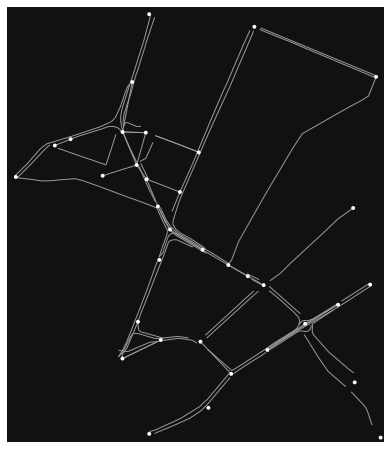

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
ox.plot_graph(graph)

Se creará un nuevo grafo donde sólo se incluirá la información de capacidad en cada edge.

In [4]:
max_graph = nx.DiGraph()
labs_dict = {}

In [5]:
for i in range(35):
    max_graph.add_node(i)
    labs_dict[i] = i

Se transferirán las conexiones realizando el cálculo de la capacidad. Se basa en la longitud de las calles dividida para la longitud de un vehículo promedio.

In [6]:
longitud_vehiculo = 4

La información de la longitud de la calle se encuentra en las edges de osmnx como `length`.

In [7]:
graph.edges[(0,16,0)]['length']

110.22899999999998

Ambas longitudes se encuentran medidas en metros.

In [8]:
for edge in graph.edges:
    max_graph.add_edge(edge[0],edge[1])
    #mantengo la capacidad en enteros
    max_graph.edges[(edge[0],edge[1])]['capacity'] = graph.edges[(edge[0],edge[1],0)]['length'] // longitud_vehiculo 

In [9]:
max_graph.edges[(0,16)]

{'capacity': 27.0}

El grafo actual tiene las capacidades de cada calle.

In [10]:
with open('coordenadas_centros.pickle', 'rb') as handle:
    pos = pickle.load(handle)

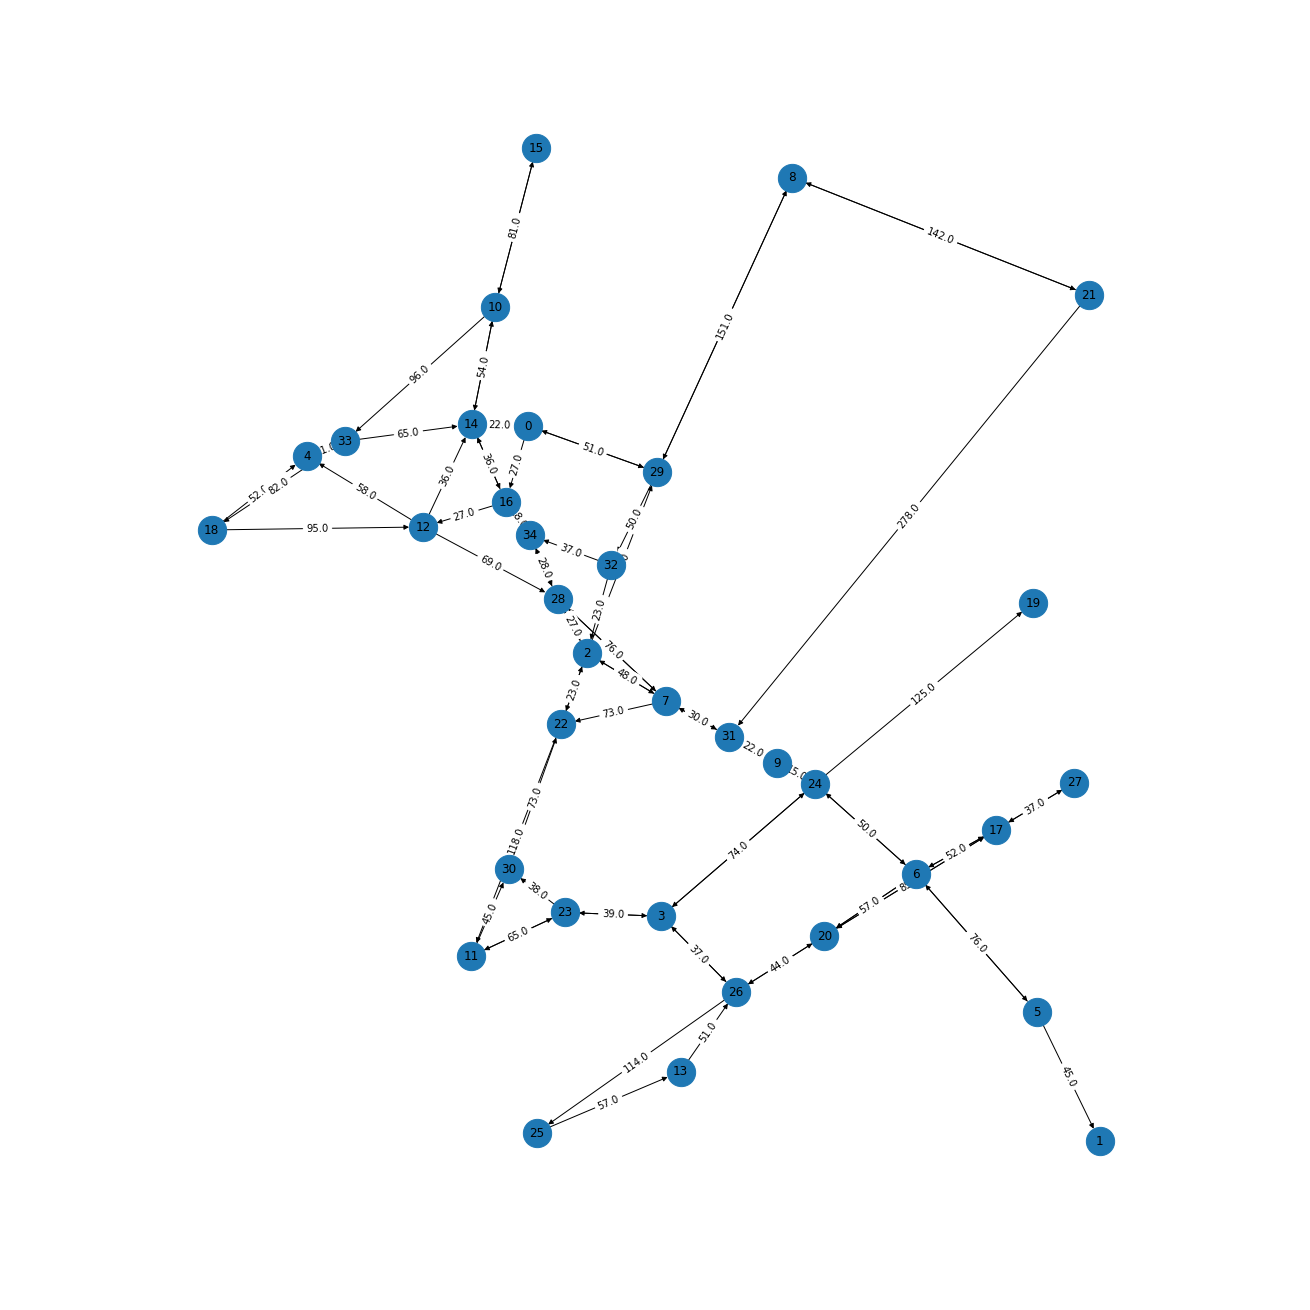

In [11]:
plt.figure(figsize=(18,18))

cap_dic = nx.get_edge_attributes(max_graph,'capacity')
nx.draw(max_graph,pos,
            node_size=800,
            labels=labs_dict, 
            with_labels = True,)
nx.draw_networkx_edge_labels(max_graph,pos,edge_labels=cap_dic)
plt.show()

Networkx tiene una implementación del flujo máximo que devuelve como resultado un diccionario.

In [12]:
nx.maximum_flow(max_graph,0,16)

(45.0,
 {0: {29: 18.0, 16: 27.0},
  1: {},
  2: {28: 0, 7: 0, 22: 0, 29: 33.0},
  3: {26: 0, 24: 0, 23: 0},
  4: {33: 0},
  5: {1: 0, 6: 0},
  6: {24: 0, 20: 0, 5: 0, 17: 0},
  7: {22: 23.0, 28: 0, 31: 0, 2: 4.0},
  8: {21: 14.0, 29: 0},
  9: {31: 0, 24: 0},
  10: {15: 0, 33: 0, 14: 0},
  11: {23: 0, 30: 0},
  12: {4: 0, 14: 0, 28: 0},
  13: {26: 0},
  14: {10: 0, 0: 0, 16: 0},
  15: {10: 0},
  16: {14: 0, 12: 0, 34: 0},
  17: {6: 0, 27: 0, 20: 0},
  18: {12: 0, 4: 0},
  19: {},
  20: {6: 0, 26: 0, 17: 0},
  21: {31: 14.0, 8: 0},
  22: {11: 0, 2: 23.0},
  23: {3: 0, 30: 0, 11: 0},
  24: {3: 0, 19: 0, 9: 0, 6: 0},
  25: {13: 0},
  26: {25: 0, 3: 0, 20: 0},
  27: {17: 0},
  28: {2: 6.0, 34: 0, 7: 13.0},
  29: {32: 37.0, 0: 0, 8: 14.0},
  30: {22: 0},
  31: {7: 14.0, 9: 0},
  32: {34: 37.0, 2: 0},
  33: {18: 0, 14: 0},
  34: {16: 18.0, 28: 19.0}})

La solución contiene el flujo máximo que se puede enviar.

In [13]:
solucion = nx.maximum_flow(max_graph,15,11)

In [14]:
solucion[0]

81.0

Y se puede construir un grafo solución a partir del diccionario.

In [15]:
graph_sol = nx.DiGraph(solucion[1])

Se elmminan las edges que no contengan flujo para simplificar el modelo.

In [16]:
remove_edges = []
good_nodes = []
for edge in graph_sol.edges:
    capacity = solucion[1][edge[0]][edge[1]]
    if(capacity!=0):
        good_nodes.append(edge[1])
        graph_sol.edges[edge]['capacity'] = capacity
    else:
        remove_edges.append(edge)

In [17]:
for edge in remove_edges:
    graph_sol.remove_edge(edge[0],edge[1])

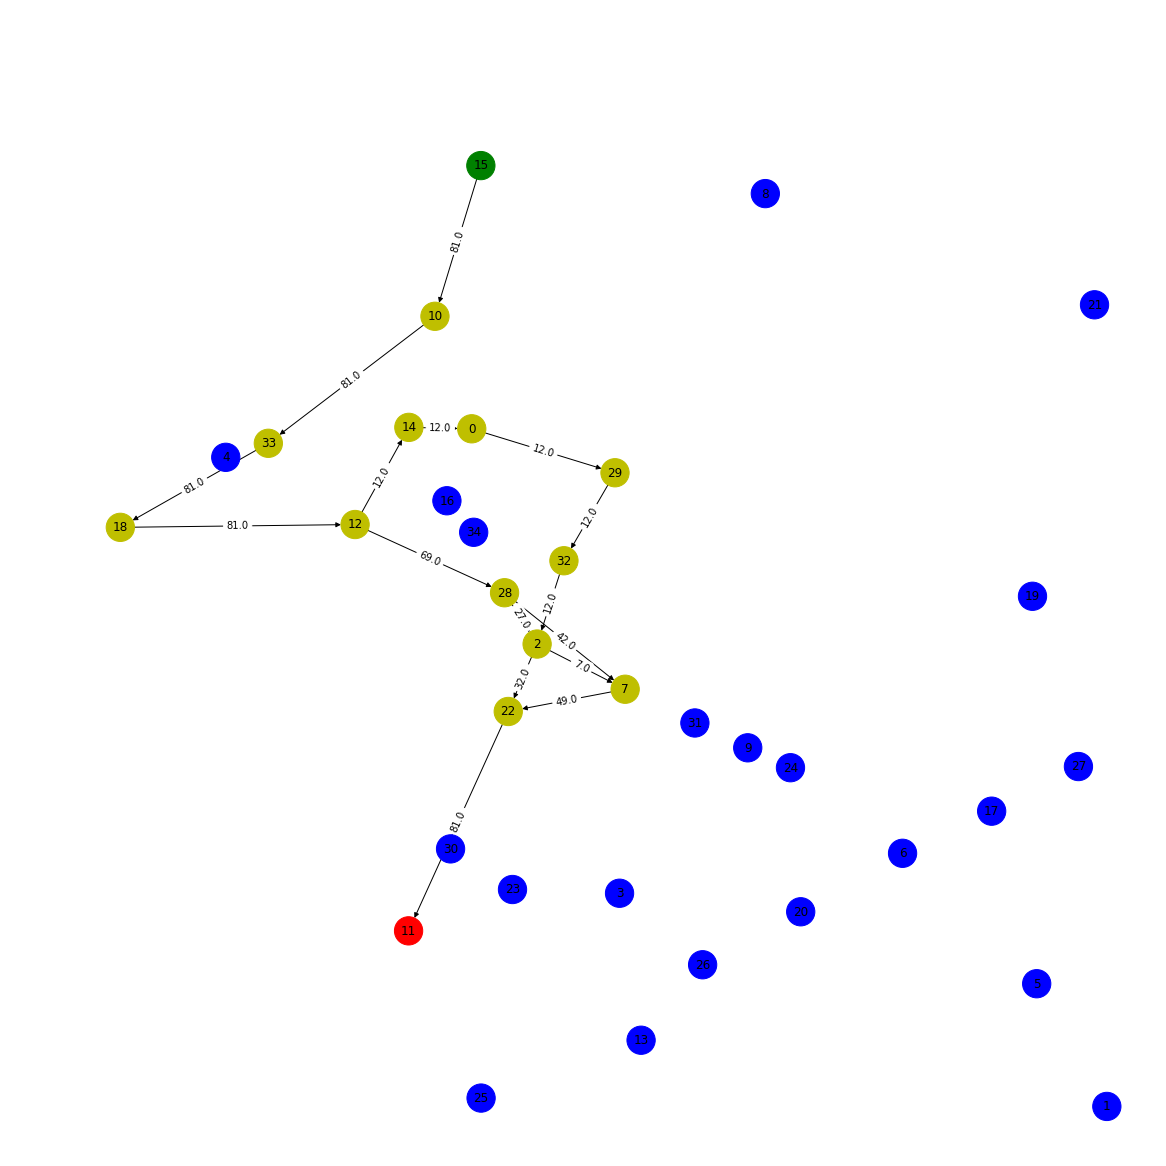

In [18]:
plt.figure(figsize=(16,16))
capacity_dic = nx.get_edge_attributes(graph_sol,'capacity')
colors = ['b']*35
for node in good_nodes:
    colors[node] = 'y'
colors[15] = 'g'
colors[11] = 'r'

nx.draw(graph_sol,pos,
            node_size=800,
            labels=labs_dict, 
            with_labels = True,
            node_color = colors)

nx.draw_networkx_edge_labels(graph_sol,pos,edge_labels=capacity_dic)

plt.show()

El proceso se automatiza con la siguiente función:

In [19]:
def get_sol_graph(graph,node1,node2):
    #se genera la solucion en un diccionario
    solucion = nx.maximum_flow(max_graph,node1,node2)    
    #se crea un grafo
    graph_sol = nx.DiGraph(solucion[1])   
    #se eliminan los edges para que sólo exista el flujo
    remove_edges = []
    good_nodes = []
    for edge in graph_sol.edges:
        capacity = solucion[1][edge[0]][edge[1]]
        if(capacity!=0):
            good_nodes.append(edge[1])
            graph_sol.edges[edge]['capacity'] = capacity
        else:
            remove_edges.append(edge)
    for edge in remove_edges:
        graph_sol.remove_edge(edge[0],edge[1])
    return graph_sol,solucion[0],good_nodes

También es útil una función para graficar el grafo.

In [20]:
def plot_sol_graph(nodo1,nodo2,graph_sol):
    plt.figure(figsize=(16,16))
    capacity_dic = nx.get_edge_attributes(graph_sol,'capacity')
    colors = ['b']*35
    for node in good_nodes:
        colors[node] = 'y'
    colors[nodo1] = 'g'
    colors[nodo2] = 'r'

    nx.draw(graph_sol,pos,
                node_size=800,
                labels=labs_dict, 
                with_labels = True,
                node_color = colors)

    nx.draw_networkx_edge_labels(graph_sol,pos,edge_labels=capacity_dic)

    plt.show()

## Distintos flujos

Con las funciones que simplifican el proceso, se pueden revisar varios flujos de tráfico en distintas direcciones. Puede imaginarse que se produce un evento importante en un área de la ciudad, como un concierto. Hay varios autos que se sabe irán al mismo punto, así que se esto permitiría reducri la congestión vehicular, haciendo que los autos se repartan por distintas rutas.

In [21]:
nodo_inicio = 18
nodo_llegada = 1
graph_sol,max_flow,good_nodes = get_sol_graph(max_graph,nodo_inicio,nodo_llegada)

In [22]:
print(max_flow)

45.0


Flujo de oeste a este.

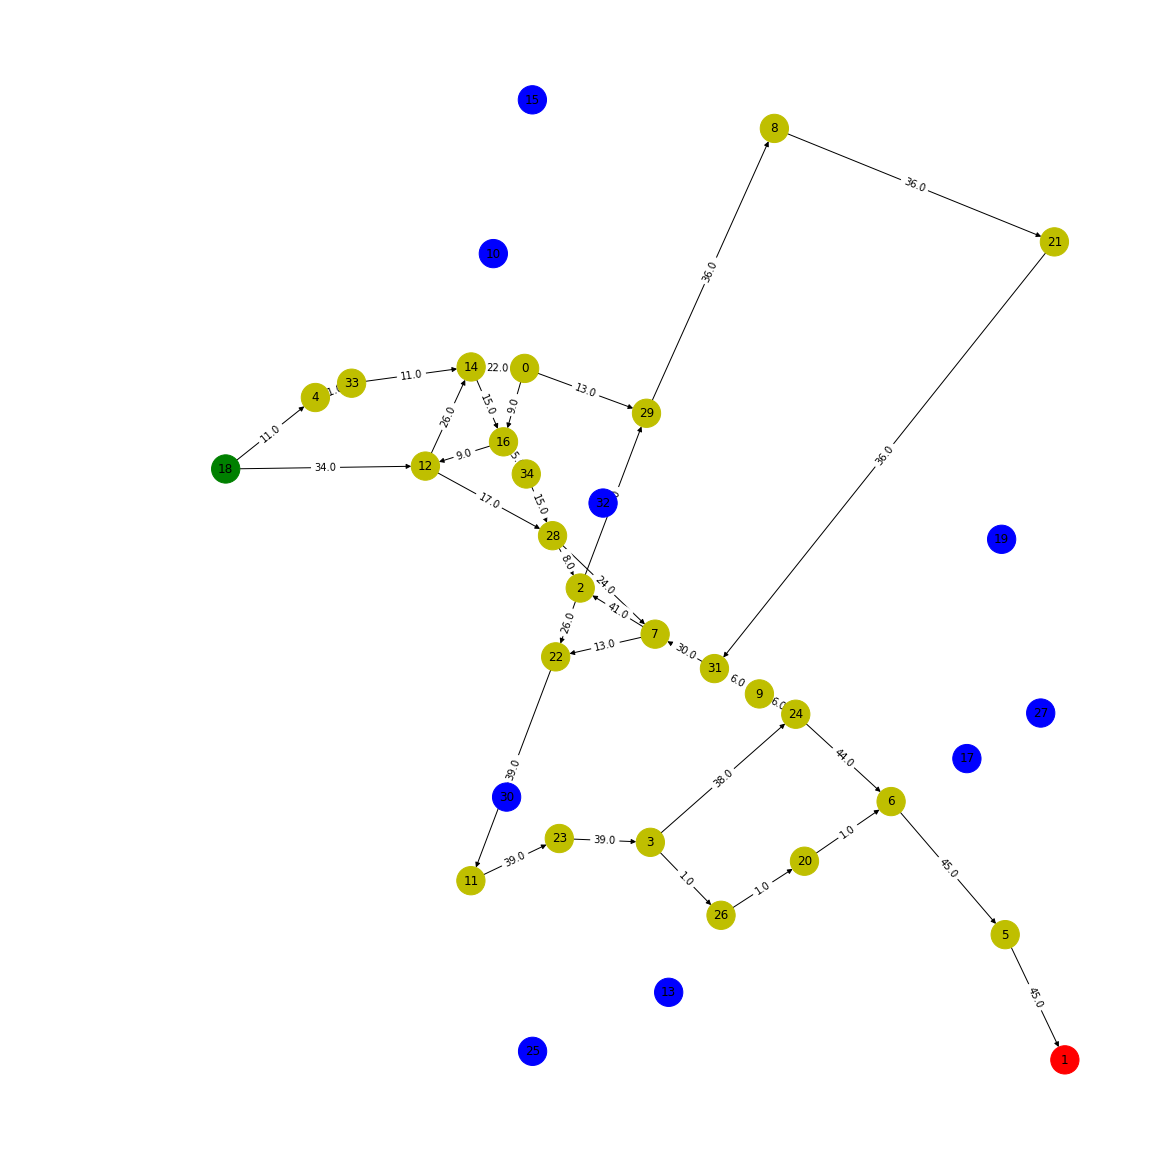

In [23]:
plot_sol_graph(nodo_inicio,nodo_llegada,graph_sol)

Flujo de este a oeste.

38.0


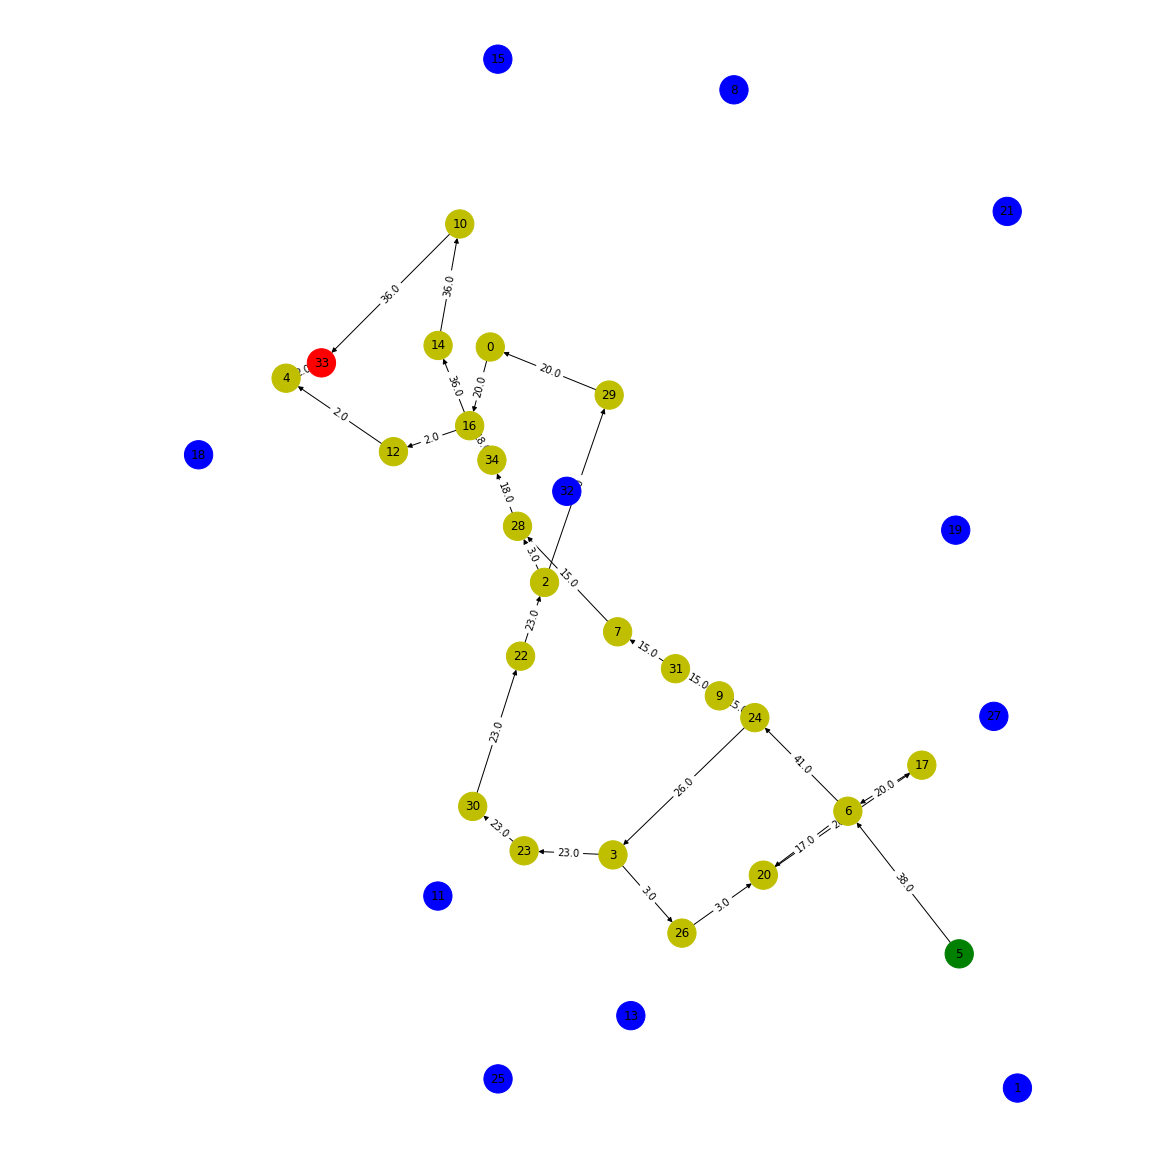

In [27]:
nodo_inicio = 5
nodo_llegada = 33
graph_sol,max_flow,good_nodes = get_sol_graph(max_graph,nodo_inicio,nodo_llegada)
print(max_flow)
plot_sol_graph(nodo_inicio,nodo_llegada,graph_sol)

Flujo de norte a sur.

51.0


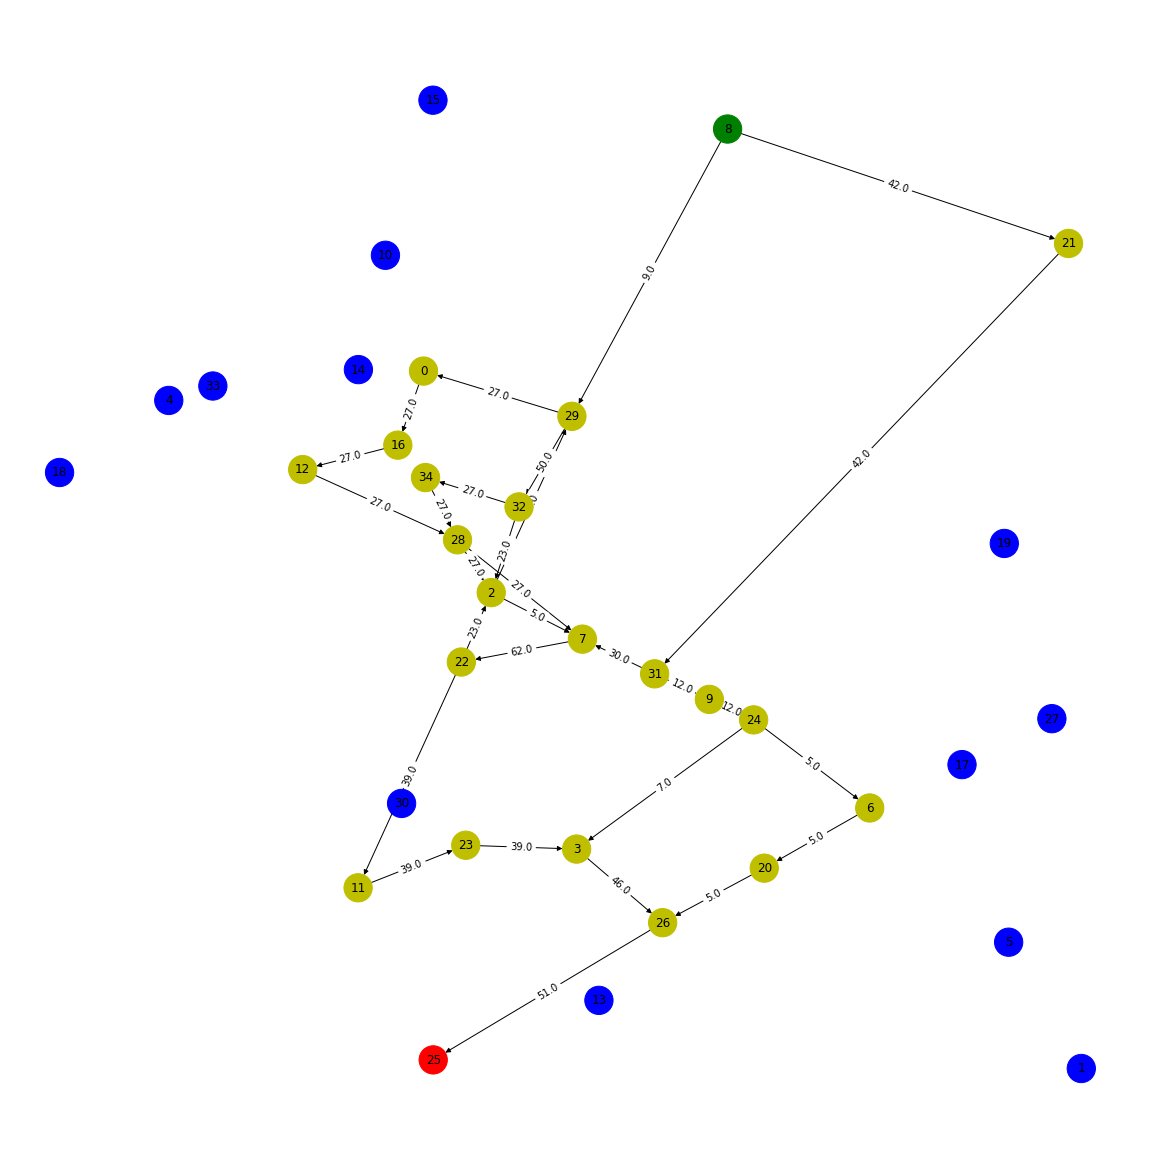

In [30]:
nodo_inicio = 8
nodo_llegada = 25
graph_sol,max_flow,good_nodes = get_sol_graph(max_graph,nodo_inicio,nodo_llegada)
print(max_flow)
plot_sol_graph(nodo_inicio,nodo_llegada,graph_sol)

Flujo de sur a norte.

38.0


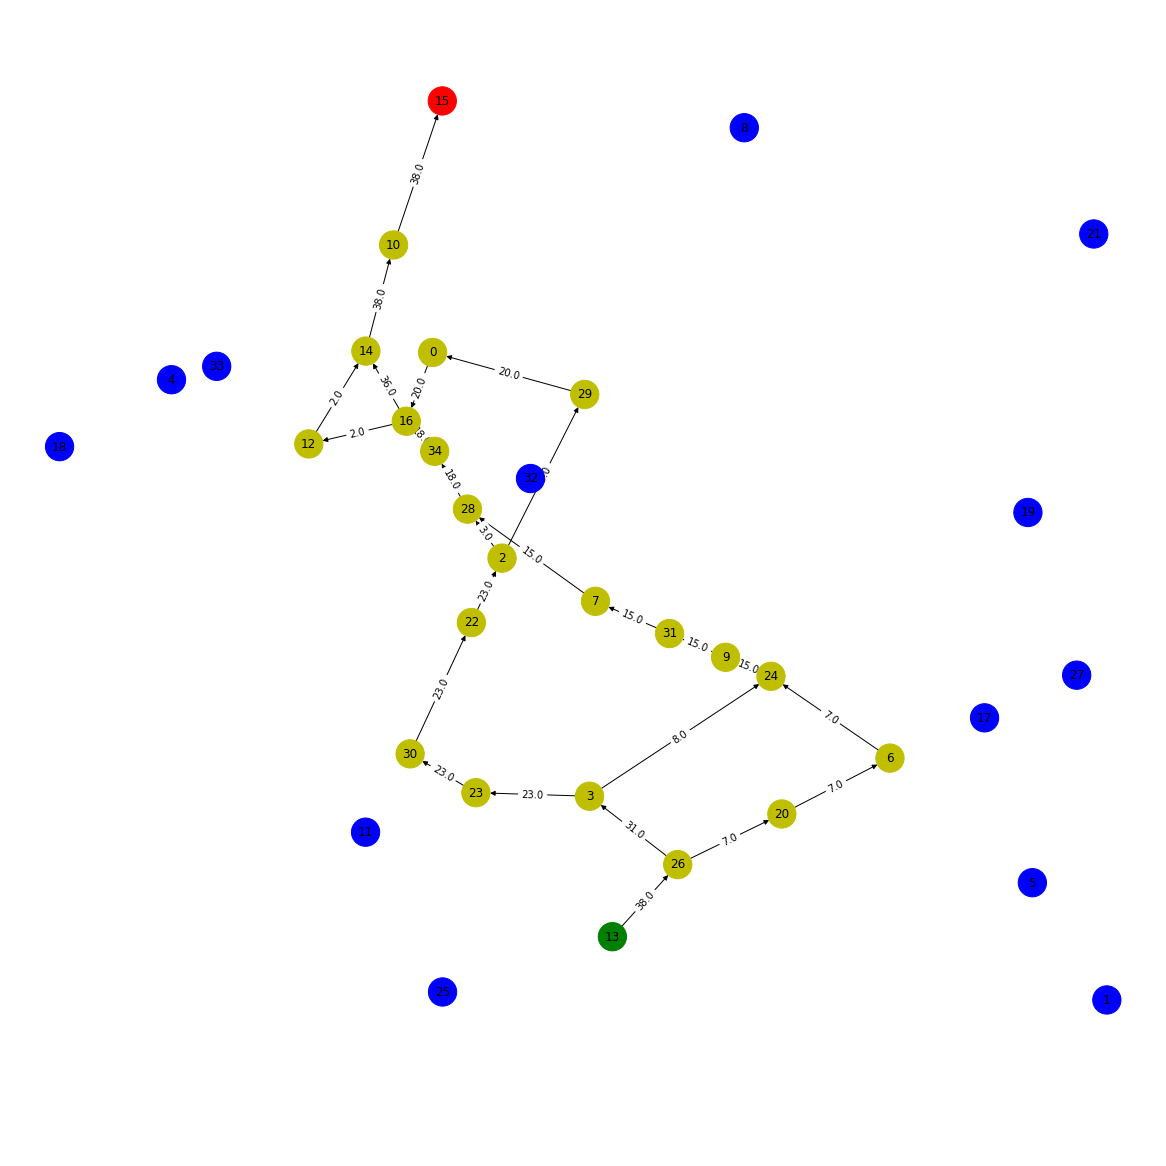

In [31]:
nodo_inicio = 13
nodo_llegada = 15
graph_sol,max_flow,good_nodes = get_sol_graph(max_graph,nodo_inicio,nodo_llegada)
print(max_flow)
plot_sol_graph(nodo_inicio,nodo_llegada,graph_sol)

## Caso de ejemplo

Flujo hacia la casa de la cultura: La casa de la cultura es un lugar bien conocido y puede producirse un evento importante que la vuelva el punto de destino del flujo vehicular.

11.0


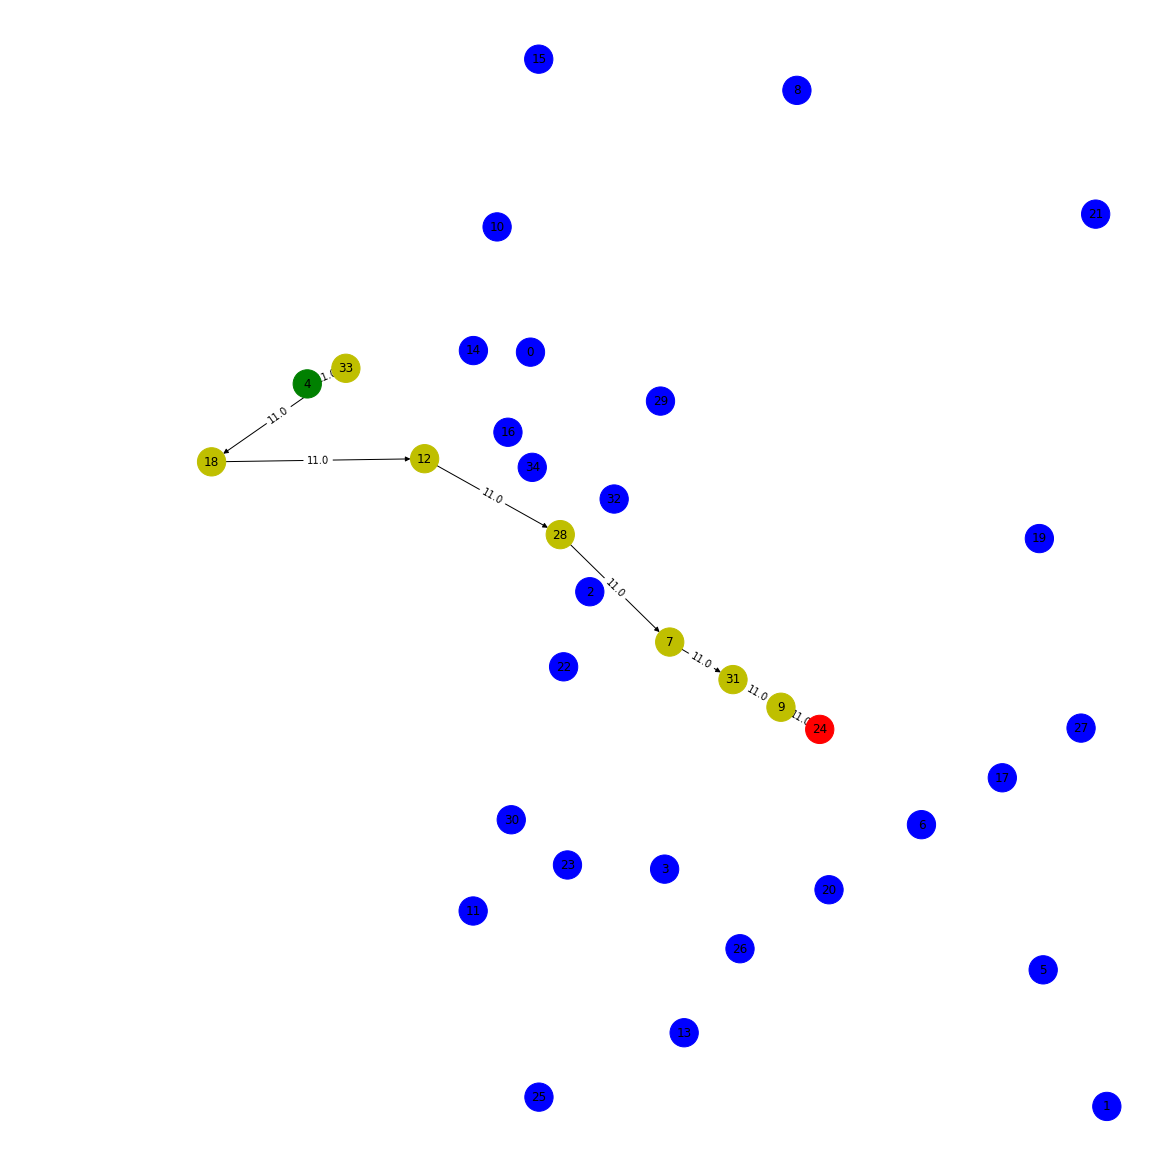

In [26]:
nodo_inicio = 4
nodo_llegada = 24 #casa de la cultura
graph_sol,max_flow,good_nodes = get_sol_graph(max_graph,nodo_inicio,nodo_llegada)
print(max_flow)
plot_sol_graph(nodo_inicio,nodo_llegada,graph_sol)

51.0


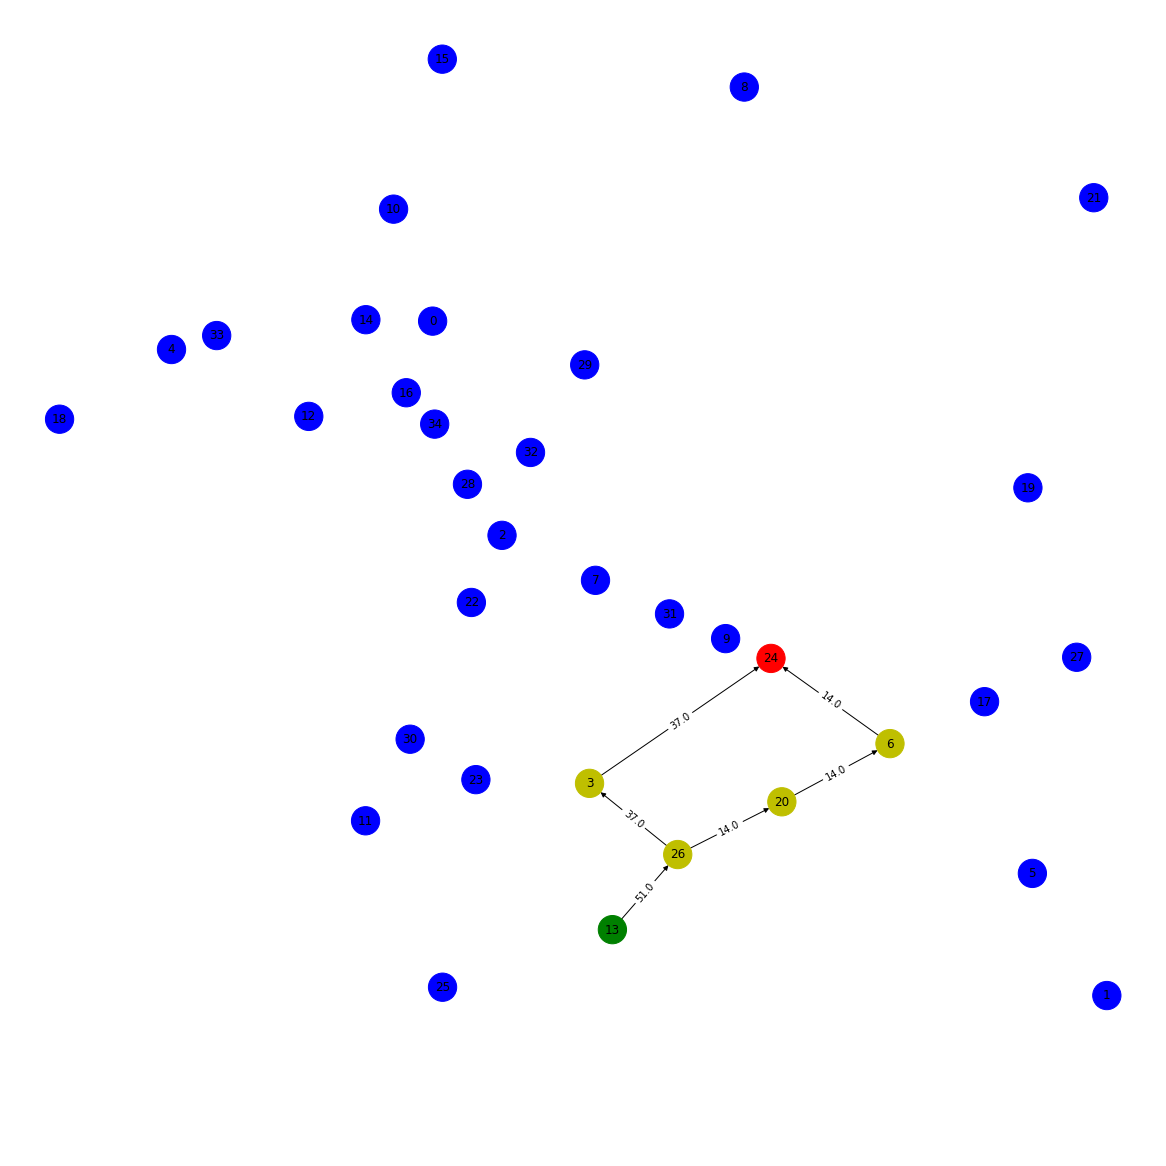

In [42]:
nodo_inicio = 13
nodo_llegada = 24 #casa de la cultura
graph_sol,max_flow,good_nodes = get_sol_graph(max_graph,nodo_inicio,nodo_llegada)
print(max_flow)
plot_sol_graph(nodo_inicio,nodo_llegada,graph_sol)